# Análisis de Posicionamiento de Precios

Este notebook analiza el posicionamiento de precios por canal, desde una vista general (familias) hasta el detalle SKU x canal.

Archivos requeridos en esta carpeta:
- `base.xlsx`: precios por SKU y canal (columnas: sku, descripción, UMV, Marca, Canal, Fuente, Precio, Peso neto UMV, Precio unitario, Fecha).
- `maestro_skus.xlsx`: maestro de SKUs (columnas: sku, categoria, familia).

Salidas esperadas: tablas resumen, KPIs (gap absoluto y porcentual, promedios, desviaciones) y gráficos útiles para detectar desviaciones relevantes.

In [1]:
# Instalación automática (si falta algo). Ejecuta esta celda si obtienes errores de importación.
import importlib, sys, subprocess
def ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        print(f'Instalando {pkg} ...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for p in ['pandas','numpy','openpyxl','matplotlib','seaborn','plotly']:
    ensure(p)
print('Dependencias listas.')

Dependencias listas.


In [2]:
# Imports y configuración de entorno
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import unicodedata, re

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set(style='whitegrid')

# Funciones utilitarias
def normalize_text(s):
    if s is None:
        return s
    s = str(s)
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    s = s.strip().lower()
    s = re.sub(r'\s+', '_', s)
    s = s.replace('%','pct')
    s = re.sub(r'[^a-z0-9_]+', '', s)
    return s

def to_numeric_safe(series):
    if series.dtype.kind in 'biufc':
        return series
    return pd.to_numeric(series.astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False), errors='coerce')

BASE_FILE = Path('base.xlsx')
MAESTRO_FILE = Path('maestro_skus.xlsx')
CANAL_INTERNO = 'interno'  # nombre exacto del canal interno en la columna 'Canal'
USAR_ULTIMA_FECHA = True   # si True, usa el último precio por SKU-Canal

BASE_FILE, MAESTRO_FILE

(WindowsPath('base.xlsx'), WindowsPath('maestro_skus.xlsx'))

## Carga de datos

In [3]:
# Leer base de precios
assert BASE_FILE.exists(), f'No se encontró {BASE_FILE.resolve()}'
try:
    df = pd.read_excel(BASE_FILE, sheet_name=0)
except Exception:
    df = pd.read_excel(BASE_FILE, sheet_name='base')

# Normalizar columnas
df.columns = [normalize_text(c) for c in df.columns]
df.rename(columns={
    'descripcion': 'descripcion',
    'peso_neto_umv': 'peso_neto_umv',
    'precio_unitario': 'precio_unitario',
    'fecha': 'fecha'
}, inplace=True)

# Tipos
for col in ['precio', 'precio_unitario', 'peso_neto_umv']:
    if col in df.columns:
        df[col] = to_numeric_safe(df[col])

if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Normalizar campo canal
if 'canal' in df.columns:
    df['canal'] = df['canal'].astype(str).str.strip().str.lower()

# Definir precio de análisis: usa precio_unitario si existe; si no, precio/UMV si se puede, si no, precio
if 'precio_unitario' in df.columns and df['precio_unitario'].notna().any():
    precio_analisis = df['precio_unitario']
else:
    if 'precio' in df.columns and 'peso_neto_umv' in df.columns:
        precio_analisis = df['precio'] / df['peso_neto_umv'].replace(0, np.nan)
    else:
        precio_analisis = df['precio'] if 'precio' in df.columns else np.nan
df['precio_analisis'] = to_numeric_safe(precio_analisis)

print('Filas en base:', len(df))
display(df.head())
df.info()

Filas en base: 938


,sku,descripcion,umv,marca,canal,fuente,precio,peso_neto_umv,precio_unitario,fecha,precio_unitario_neto,fuente_comercial,precio_analisis
0,104500500,"QUESO MOZZARELLA MOLFINO 3,5 kg",NaN,NaN,interno,LP,"6,590.00",1.00,"6,590.00",2025-10-17,NaN,LP,"6,590.00"
1,104519930,"QUESO GAUDA MOLFINO 3,9 kg",NaN,NaN,interno,LP,"6,990.00",1.00,"6,990.00",2025-10-17,NaN,LP,"6,990.00"
2,104520790,"QUESO MOZZARELLA HEBRA LEPRINO 6,8 kg",NaN,NaN,interno,LP,"56,800.00",6.80,"8,352.94",2025-10-17,NaN,LP,"8,352.94"
3,104529870,"QUESO CHEDDAR LAMINADO LUNCHITAS 2,26 kg",NaN,NaN,interno,LP,"65,000.00",9.04,"7,190.27",2025-10-17,NaN,LP,"7,190.27"
4,104527430,"PAPA 12 mm AVIKO 2,5 kg",NaN,NaN,interno,LP,"23,000.00",10.00,"2,300.00",2025-10-17,NaN,LP,"2,300.00"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   sku                   938 non-null    int64         
 1   descripcion           938 non-null    object        
 2   umv                   190 non-null    object        
 3   marca                 34 non-null     object        
 4   canal                 938 non-null    object        
 5   fuente                935 non-null    object        
 6   precio                919 non-null    float64       
 7   peso_neto_umv         917 non-null    float64       
 8   precio_unitario       916 non-null    float64       
 9   fecha                 667 non-null    datetime64[ns]
 10  precio_unitario_neto  0 non-null      float64       
 11  fuente_comercial      938 non-null    object        
 12  precio_analisis       916 non-null    float64       
dtypes: datetime64[ns](1)

In [4]:
# Leer maestro de SKUs
assert MAESTRO_FILE.exists(), f'No se encontró {MAESTRO_FILE.resolve()}'
maestro = pd.read_excel(MAESTRO_FILE, sheet_name=0)
maestro.columns = [normalize_text(c) for c in maestro.columns]
keep = [c for c in ['sku','categoria','familia'] if c in maestro.columns]
maestro = maestro[keep].drop_duplicates()
maestro['sku'] = maestro['sku'].astype(str).str.strip()
print('Filas en maestro:', len(maestro))
display(maestro.head())

Filas en maestro: 9475


,sku,categoria,familia
0,104512230,ACEITES Y VINAGRES,ACEITES DE OLIVA
1,104514840,ACEITES Y VINAGRES,ACEITES DE OLIVA
2,104514850,ACEITES Y VINAGRES,ACEITES DE OLIVA
3,104514860,ACEITES Y VINAGRES,ACEITES DE OLIVA
4,104521640,ACEITES Y VINAGRES,ACEITES DE OLIVA


## Limpieza y selección de último precio por SKU-Canal

In [5]:
# Asegurar tipos y claves de unión
df['sku'] = df['sku'].astype(str).str.strip()
if USAR_ULTIMA_FECHA and 'fecha' in df.columns:
    df_sorted = df.sort_values(['sku','canal','fecha'])
    df_latest = df_sorted.drop_duplicates(subset=['sku','canal'], keep='last')
else:
    df_latest = df.copy()

# Merge con maestro
data = df_latest.merge(maestro, on='sku', how='left')
cov = data['familia'].notna().mean() if 'familia' in data.columns else np.nan
print('Cobertura de maestro en data:', f'{cov:.1%}')
display(data.head())

# Diagnóstico general
print('Rango de fechas:', data['fecha'].min(), '→', data['fecha'].max())
display(data['canal'].value_counts().rename('filas_por_canal').to_frame())
display(data.groupby('canal')['precio_analisis'].agg(['count','mean','median','std']).sort_values('mean', ascending=False))

Cobertura de maestro en data: 100.0%


,sku,descripcion,umv,marca,canal,fuente,precio,peso_neto_umv,precio_unitario,fecha,precio_unitario_neto,fuente_comercial,precio_analisis,categoria,familia
0,100093620,JALEA EN POLVO FRAMBUESA CARICIA 1 kg,NaN,NaN,interno,LP,"46,500.00",10.00,"4,650.00",2025-10-17,NaN,LP,"4,650.00",BOLLERIA,POSTRES EN POLVO
1,100093620,JALEA EN POLVO FRAMBUESA CARICIA 1 kg,NaN,NaN,interno,LP,"46,500.00",10.00,"4,650.00",2025-10-17,NaN,LP,"4,650.00",REPOSTERIA,POSTRES EN POLVO
2,100093620,JALEA EN POLVO FRAMBUESA CARICIA 1 kg,NaN,NaN,mayorista,https://www.centralmayorista.cl/p/gelatina-polvo-frambuesa-1kg-caricia-425549,"4,890.00",1.00,"4,109.24",NaT,NaN,central mayorista,"4,109.24",BOLLERIA,POSTRES EN POLVO
3,100093620,JALEA EN POLVO FRAMBUESA CARICIA 1 kg,NaN,NaN,mayorista,https://www.centralmayorista.cl/p/gelatina-polvo-frambuesa-1kg-caricia-425549,"4,890.00",1.00,"4,109.24",NaT,NaN,central mayorista,"4,109.24",REPOSTERIA,POSTRES EN POLVO
4,100093780,JALEA EN POLVO NARANJA CARICIA 1 kg,NaN,NaN,interno,LP,"46,500.00",10.00,"4,650.00",2025-10-17,NaN,LP,"4,650.00",BOLLERIA,POSTRES EN POLVO


Rango de fechas: 2025-10-17 00:00:00 → 2025-10-28 00:00:00


,filas_por_canal
canal,
interno,547
retail,255
mayorista,145
distribuidora,68


,count,mean,median,std
canal,,,,
interno,526,"14,724.99","5,204.17","121,776.99"
retail,253,"8,803.33","5,441.78","12,650.54"
mayorista,145,"6,443.93","4,109.24","7,880.06"
distribuidora,67,"6,154.52","4,157.71","8,216.57"


## Comparación canal interno vs resto (a nivel SKU)

In [6]:
# Prepara precios internos y externos por SKU
interno = (data.query('canal == @CANAL_INTERNO')[['sku','precio_analisis']]
           .groupby('sku', as_index=False)['precio_analisis'].median()
          ).rename(columns={'precio_analisis':'precio_interno'})
externo = (data.query('canal != @CANAL_INTERNO')[['sku','precio_analisis','canal']]
           .groupby('sku', as_index=False)
           .agg(precio_externo=('precio_analisis','mean'), canales_externos=('canal','nunique'))
          )

sku_comp = maestro[['sku','categoria','familia']].merge(interno, on='sku', how='left').merge(externo, on='sku', how='left')
if 'descripcion' in data.columns:
    sku_comp = sku_comp.merge(data[['sku','descripcion']].drop_duplicates('sku'), on='sku', how='left')
sku_comp['gap_abs'] = sku_comp['precio_externo'] - sku_comp['precio_interno']
sku_comp['gap_pct'] = np.where(sku_comp['precio_interno']>0, sku_comp['precio_externo']/sku_comp['precio_interno'] - 1, np.nan)

# Estadísticas por SKU entre canales
stats_por_sku = (data.groupby(['sku'])['precio_analisis']
                  .agg(media_precio=('mean'), std_precio=('std'), min_precio=('min'), max_precio=('max'), conteo=('count'))
                 )
sku_comp = sku_comp.merge(stats_por_sku, on='sku', how='left')

print('SKUs con comparables (interno y al menos un externo):',
      ((sku_comp['precio_interno'].notna()) & (sku_comp['precio_externo'].notna())).sum())
display(sku_comp.head(10))

SKUs con comparables (interno y al menos un externo): 326


,sku,categoria,familia,precio_interno,precio_externo,canales_externos,descripcion,gap_abs,gap_pct,media_precio,std_precio,min_precio,max_precio,conteo
0,104512230,ACEITES Y VINAGRES,ACEITES DE OLIVA,"9,100.00","16,789.92",1.00,ACEITE OLIVA E/VIRGEN OLITALIA 5 l,"7,689.92",0.85,"12,944.96","5,437.59","9,100.00","16,789.92",2.00
1,104514840,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104514850,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104514860,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104521640,ACEITES Y VINAGRES,ACEITES DE OLIVA,"8,000.00","8,065.55",2.00,ACEITE OLIVA NUTRICAMPO 5 l,65.55,0.01,"8,043.70","1,503.62","6,384.87","9,746.22",6.00
5,104524420,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,"13,445.38",1.00,ACEITE OLIVA E/VIRGEN ZAYTA 500 ml,NaN,NaN,"13,445.38",NaN,"13,445.38","13,445.38",1.00
6,104531070,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,104531110,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,104537630,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,"10,067.23",1.00,ACEITE OLIVA NUTRICAMPO 500 ML,NaN,NaN,"10,067.23",NaN,"10,067.23","10,067.23",1.00
9,104539450,ACEITES Y VINAGRES,ACEITES DE OLIVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Top desviaciones por SKU

In [7]:
# Pivot SKU x Canal de precios
pivot = data.pivot_table(index='sku', columns='canal', values='precio_analisis', aggfunc='median')
if CANAL_INTERNO not in pivot.columns:
    print(f'Advertencia: no hay columna de canal interno = {CANAL_INTERNO!r} en los datos pivot.')

ratios = {}
for canal in pivot.columns:
    if canal == CANAL_INTERNO:
        continue
    ratios[canal] = (pivot[canal] / pivot[CANAL_INTERNO])

ratios_df = pd.DataFrame(ratios)
# Reemplazar infinitos por NaN para evitar promedios 'inf'
ratios_df = ratios_df.replace([np.inf, -np.inf], np.nan)
res_canal = pd.DataFrame({
    'ratio_promedio_vs_interno': ratios_df.mean(skipna=True),
    'ratio_mediana_vs_interno': ratios_df.median(skipna=True),
    'observaciones': ratios_df.count()
}).sort_values('ratio_promedio_vs_interno', ascending=False)
display(res_canal)

fig6 = px.bar(res_canal.reset_index(), x='index', y='ratio_promedio_vs_interno', title='Promedio de (precio canal / precio interno) por canal')
fig6.update_layout(xaxis_title='Canal', yaxis_title='Ratio promedio vs interno')
fig6.show()

,ratio_promedio_vs_interno,ratio_mediana_vs_interno,observaciones
retail,1.20,1.13,204
mayorista,1.06,0.97,119
distribuidora,0.99,0.92,55


In [8]:
sku_ok = sku_comp.dropna(subset=['precio_interno','precio_externo']).copy()
# Winsorización por signo (solo para graficar)
neg = sku_ok['gap_abs'] < 0
pos = sku_ok['gap_abs'] > 0
cap_pos = sku_ok.loc[pos, 'gap_abs'].quantile(0.99) if pos.any() else np.nan
cap_neg = sku_ok.loc[neg, 'gap_abs'].abs().quantile(0.99) if neg.any() else np.nan
sku_ok['gap_abs_clip'] = sku_ok['gap_abs']
sku_ok.loc[pos, 'gap_abs_clip'] = sku_ok.loc[pos, 'gap_abs'].clip(upper=cap_pos)
sku_ok.loc[neg, 'gap_abs_clip'] = -np.minimum(sku_ok.loc[neg, 'gap_abs'].abs(), cap_neg)
sku_ok['sku_label'] = sku_ok['sku'].astype(str)
if 'descripcion' in sku_ok.columns:
    sku_ok['sku_label'] = sku_ok['descripcion'].fillna(sku_ok['sku_label'])
top_pos = sku_ok.sort_values('gap_abs', ascending=False).head(20)
top_neg = sku_ok.sort_values('gap_abs', ascending=True).head(20)
display(top_pos[['sku','familia','precio_interno','precio_externo','gap_abs','gap_pct','canales_externos']])
display(top_neg[['sku','familia','precio_interno','precio_externo','gap_abs','gap_pct','canales_externos']])

fig1 = px.bar(top_pos, y='sku_label', x='gap_abs_clip', orientation='h', color='familia', title='Top 20 SKU con mayor gap positivo (externo > interno)')
fig1.update_layout(xaxis_title='Gap absoluto (cap p99 por signo)', yaxis_title='SKU', yaxis={'automargin':True}, margin=dict(l=220))
fig1.show()

fig2 = px.bar(top_neg, y='sku_label', x='gap_abs_clip', orientation='h', color='familia', title='Top 20 SKU con mayor gap negativo (interno > externo)')
fig2.update_layout(xaxis_title='Gap absoluto (cap p99 por signo)', yaxis_title='SKU', yaxis={'automargin':True}, margin=dict(l=220))
fig2.show()

fig3 = px.histogram(sku_ok, x='gap_pct', nbins=50, title='Distribución gap porcentual (externo vs interno)')
fig3.update_layout(xaxis_title='Gap %', yaxis_title='Frecuencia')
fig3.show()

,sku,familia,precio_interno,precio_externo,gap_abs,gap_pct,canales_externos
1246,201700307,ESPECIAS,"19,500.00","79,831.93","60,331.93",3.09,1.00
6421,104501190,MINI PORCIONES,"18,990.00","37,932.77","18,942.77",1.00,1.00
6339,102310110,DULCES Y CHOCOLATES,"26,578.85","40,239.17","13,660.33",0.51,1.00
1245,201700306,ESPECIAS,"13,000.00","24,089.64","11,089.64",0.85,1.00
7082,104543030,MANTEQUILLA Y MARGARINA,0.00,"8,781.51","8,781.51",NaN,1.00
1429,104542770,VERDURAS,"5,208.33","13,620.45","8,412.11",1.62,1.00
0,104512230,ACEITES DE OLIVA,"9,100.00","16,789.92","7,689.92",0.85,1.00
6428,104522200,MINI PORCIONES,"9,450.00","16,789.92","7,339.92",0.78,1.00
1049,150000188,TE Y OTRAS BEBIDAS CALIENTES,"22,257.83","29,411.76","7,153.93",0.32,1.00
958,150000188,DESCONTINUADOS,"22,257.83","29,411.76","7,153.93",0.32,1.00


,sku,familia,precio_interno,precio_externo,gap_abs,gap_pct,canales_externos
7652,201222280,MINI PORCIONES,"2,772,337.50","2,773.11","-2,769,564.39",-1.00,1.00
4054,102310250,Ferrero - Ferrero,"42,105.26","19,346.41","-22,758.86",-0.54,1.00
6340,102310250,DULCES Y CHOCOLATES,"42,105.26","19,346.41","-22,758.86",-0.54,1.00
804,104521140,CAFES SOLUBLES,"82,500.00","64,128.86","-18,371.14",-0.22,3.00
807,150001266,CAFES SOLUBLES,"45,634.92","30,872.35","-14,762.57",-0.32,2.00
5481,102320340,Chocolates - Rocher - Rocher,"52,000.00","44,201.68","-7,798.32",-0.15,1.00
6345,102320340,DULCES Y CHOCOLATES,"52,000.00","44,201.68","-7,798.32",-0.15,1.00
1012,101710090,TE Y OTRAS BEBIDAS CALIENTES,"15,555.56","9,537.82","-6,017.74",-0.39,1.00
6800,104519860,SALMONES,"21,580.00","16,210.08","-5,369.92",-0.25,2.00
6774,104519860,PESCADOS,"21,580.00","16,210.08","-5,369.92",-0.25,2.00


## Agregado: Categoría | Familia (Top 15 ± y box horizontal)

In [9]:
fam_cf = (sku_ok.groupby(['categoria','familia'])
          .agg(skus=('sku','nunique'),
               precio_interno_prom=('precio_interno','mean'),
               precio_externo_prom=('precio_externo','mean'),
               gap_abs_prom=('gap_abs','mean'),
               gap_pct_prom=('gap_pct','mean')).reset_index())
fam_cf['cat_fam'] = fam_cf['categoria'].astype(str) + ' | ' + fam_cf['familia'].astype(str)
# Top 15 positivo
pos15 = fam_cf[fam_cf['gap_abs_prom']>0].sort_values('gap_abs_prom', ascending=False).head(15)
fig_pos15 = px.bar(pos15, y='cat_fam', x='gap_abs_prom', orientation='h', title='Top 15 gap promedio positivo por Categoría | Familia')
fig_pos15.update_layout(yaxis={'automargin':True}, xaxis_title='Gap promedio', yaxis_title='Categoría | Familia', margin=dict(l=420), height=max(500, 26*len(pos15)+220))
fig_pos15.add_vline(x=0, line_dash='dot', line_color='gray')
fig_pos15.show()
# Top 15 negativo
neg15 = fam_cf[fam_cf['gap_abs_prom']<0].sort_values('gap_abs_prom', ascending=True).head(15)
fig_neg15 = px.bar(neg15, y='cat_fam', x='gap_abs_prom', orientation='h', title='Top 15 gap promedio negativo por Categoría | Familia')
fig_neg15.update_layout(yaxis={'automargin':True}, xaxis_title='Gap promedio', yaxis_title='Categoría | Familia', margin=dict(l=420), height=max(500, 26*len(neg15)+220))
fig_neg15.add_vline(x=0, line_dash='dot', line_color='gray')
fig_neg15.show()
# Boxplot horizontal gap % por Categoría | Familia
df_box = sku_ok.merge(fam_cf[['categoria','familia','cat_fam']], on=['categoria','familia'], how='left')
fig_box_cf = px.box(df_box, y='cat_fam', x='gap_pct', points='outliers', title='Distribución gap % por Categoría | Familia')
fig_box_cf.update_layout(yaxis={'automargin':True}, xaxis_title='Gap %', yaxis_title='Categoría | Familia', margin=dict(l=420), height=max(800, 22*df_box['cat_fam'].nunique()+220), yaxis_tickfont_size=10)
fig_box_cf.add_vline(x=0, line_dash='dot', line_color='gray')
fig_box_cf.show()


## Heatmap: ratio por Familia y Canal (vs interno)

<>:18: SyntaxWarning:

"\|" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\|"? A raw string is also an option.

<>:18: SyntaxWarning:

"\|" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\|"? A raw string is also an option.

C:\Users\SebastiánIgnacioCata\AppData\Local\Temp\ipykernel_7488\4204667659.py:18: SyntaxWarning:

"\|" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\|"? A raw string is also an option.

c:\Users\SebastiánIgnacioCata\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 141 (\x8d) missing from font(s) Arial.

C:\Users\SebastiánIgnacioCata\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 141 (\x8d) missing from font(s) Arial.



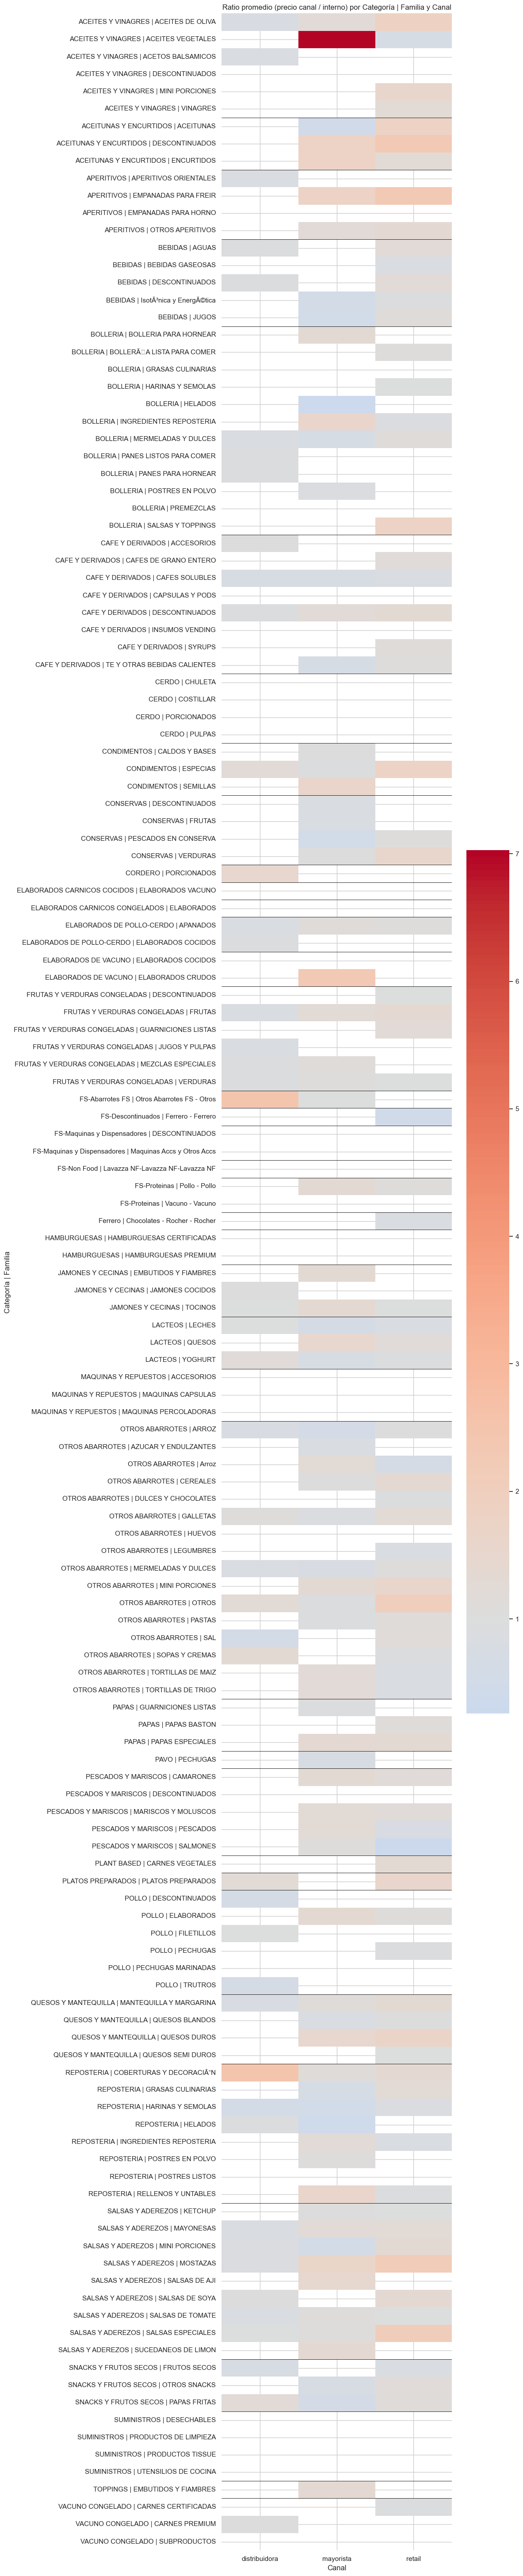

In [10]:
# Calcular ratio por SKU-Canal vs interno y luego promediar por Categoría | Familia
base_ratios = data.merge(interno.rename(columns={'precio_interno':'precio_interno_ref'}), on='sku', how='left')
base_ratios = base_ratios[base_ratios['precio_interno_ref'].notna() & (base_ratios['precio_interno_ref'] > 0)].copy()
base_ratios['ratio_vs_interno'] = base_ratios['precio_analisis'] / base_ratios['precio_interno_ref']
base_ratios = base_ratios.replace([np.inf,-np.inf], np.nan).dropna(subset=['ratio_vs_interno'])
base_ratios['cat_fam'] = base_ratios['categoria'].astype(str) + ' | ' + base_ratios['familia'].astype(str)
fam_canal = (base_ratios[base_ratios['canal'] != CANAL_INTERNO]
             .groupby(['cat_fam','canal'])['ratio_vs_interno']
             .mean().unstack('canal'))
# Ordenar por categoría y familia para que el heatmap agrupe correctamente
orden_cf = (base_ratios[['cat_fam','categoria','familia']]
            .drop_duplicates()
            .sort_values(['categoria','familia'])['cat_fam'])
fam_canal = fam_canal.reindex(orden_cf)
plt.figure(figsize=(12, max(4, len(fam_canal)*0.4)))
ax = sns.heatmap(fam_canal, annot=False, cmap='coolwarm', center=1.0)
# Separadores visuales entre categorías para que no se vea todo junto
_cats = orden_cf.str.split(' \| ').str[0].tolist()
_bounds = [i for i in range(1, len(_cats)) if _cats[i] != _cats[i-1]]
for b in _bounds:
    ax.hlines(b, *ax.get_xlim(), colors='black', linewidth=0.6)
plt.title('Ratio promedio (precio canal / interno) por Categoría | Familia y Canal')
plt.xlabel('Canal')
plt.ylabel('Categoría | Familia')
plt.tight_layout()
plt.show()

## Detalle por SKU x Fuente (precios comparados)

In [11]:
# Comparativo por SKU x Fuente (usa 'fuente_comercial' si existe)
df_src = data.copy()
col_fuente = 'fuente_comercial' if 'fuente_comercial' in df_src.columns else 'fuente'
df_src['fuente_limpia'] = np.where(df_src['canal'] == CANAL_INTERNO, 'interno', df_src[col_fuente].astype(str).str.strip().str.lower())
df_src = df_src.dropna(subset=['sku','precio_analisis'])
df_src = (df_src.sort_values(['sku','fuente_limpia','fecha'])
                .drop_duplicates(subset=['sku','fuente_limpia'], keep='last'))
pvt = (df_src.pivot_table(index=['sku'], columns='fuente_limpia', values='precio_analisis', aggfunc='first').reset_index())
# agregar metadatos (si están disponibles)
meta_cols = [c for c in ['sku','descripcion','categoria','familia'] if c in data.columns]
if meta_cols:
    pvt = data.drop_duplicates('sku')[meta_cols].merge(pvt, on='sku', how='left')
# métricas fila
cols_fuentes = [c for c in pvt.columns if c not in ['sku','descripcion','categoria','familia','interno']]
pvt['min_ext'] = pvt[cols_fuentes].min(axis=1, skipna=True)
pvt['max_ext'] = pvt[cols_fuentes].max(axis=1, skipna=True)
pvt['fuente_min'] = pvt[cols_fuentes].idxmin(axis=1)
pvt['fuente_max'] = pvt[cols_fuentes].idxmax(axis=1)
pvt['gap_min_pct'] = np.where(pvt.get('interno').notna() & pvt['min_ext'].notna(), pvt['min_ext']/pvt['interno'] - 1, np.nan)
pvt['gap_max_pct'] = np.where(pvt.get('interno').notna() & pvt['max_ext'].notna(), pvt['max_ext']/pvt['interno'] - 1, np.nan)
# estilo para notebook
def _style_row(s):
    styles = [''] * len(s)
    idx = {c:i for i,c in enumerate(s.index)}
    if 'interno' in idx and pd.notna(s['interno']):
        styles[idx['interno']] = 'background-color:#FFF3CD'
    ext_vals = s[cols_fuentes]
    if ext_vals.notna().any():
        cmin = ext_vals.idxmin(); cmax = ext_vals.idxmax()
        styles[idx[cmin]] = 'background-color:#D1F5E1'
        styles[idx[cmax]] = 'background-color:#F8D7DA'
    return styles
cols_show = ['sku'] + [c for c in ['descripcion','categoria','familia'] if c in pvt.columns] + ['interno'] + cols_fuentes + ['min_ext','max_ext','fuente_min','fuente_max','gap_min_pct','gap_max_pct']
styled = (pvt[cols_show]
              .style.apply(_style_row, axis=1, subset=cols_show)
              .format({c: '{:,.0f}' for c in (['interno','min_ext','max_ext'] + cols_fuentes) if c in pvt})
              .format({'gap_min_pct':'{:+.1%}','gap_max_pct':'{:+.1%}'}))
display(styled)


C:\Users\SebastiánIgnacioCata\AppData\Local\Temp\ipykernel_7488\2070735447.py:17: FutureWarning:

The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError

C:\Users\SebastiánIgnacioCata\AppData\Local\Temp\ipykernel_7488\2070735447.py:18: FutureWarning:

The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



,sku,descripcion,categoria,familia,interno,bidfood,central mayorista,jumbo,otros,min_ext,max_ext,fuente_min,fuente_max,gap_min_pct,gap_max_pct
0,100093620,JALEA EN POLVO FRAMBUESA CARICIA 1 kg,BOLLERIA,POSTRES EN POLVO,4650.000000,nan,4109.243697,nan,nan,4109.243697,4109.243697,central mayorista,central mayorista,-11.6%,-11.6%
1,100093780,JALEA EN POLVO NARANJA CARICIA 1 kg,BOLLERIA,POSTRES EN POLVO,4650.000000,nan,4109.243697,nan,nan,4109.243697,4109.243697,central mayorista,central mayorista,-11.6%,-11.6%
2,101310213,CACAO AMARGO EDRA 1 Kg,REPOSTERIA,INGREDIENTES REPOSTERIA,11500.000000,nan,20140.056022,nan,9243.697479,9243.697479,20140.056022,otros,central mayorista,-19.6%,+75.1%
3,101500120,"CHAMPIÃ‘ON LAMINADO ZANAFOODS 2,84 kg",CONSERVAS,VERDURAS,2670.187793,nan,nan,nan,nan,nan,nan,nan,nan,+nan%,+nan%
4,101520140,PALMITOS ESMERALDA 810 g,CONSERVAS,VERDURAS,4444.444444,nan,nan,nan,5591.866376,5591.866376,5591.866376,otros,otros,+25.8%,+25.8%
5,101520250,PALMITOS RODAJAS ESMERALDA 810 g,CONSERVAS,VERDURAS,3209.876543,nan,3340.336134,nan,nan,3340.336134,3340.336134,central mayorista,central mayorista,+4.1%,+4.1%
6,101530550,PIÃ‘A EN RODAJAS ZANAFOODS 3 KG,CONSERVAS,FRUTAS,nan,nan,nan,nan,nan,nan,nan,nan,nan,+nan%,+nan%
7,101710090,TE EMBLEM CEYLAN IMP 100 BLS,CAFE Y DERIVADOS,TE Y OTRAS BEBIDAS CALIENTES,15555.555556,nan,9537.815126,nan,nan,9537.815126,9537.815126,central mayorista,central mayorista,-38.7%,-38.7%
8,101710133,TE CLUB ORIGINAL IMP 100BLS,CAFE Y DERIVADOS,TE Y OTRAS BEBIDAS CALIENTES,16500.000000,nan,nan,nan,nan,nan,nan,nan,nan,+nan%,+nan%
9,101710137,TE EMBLEM CEYLAN PREMIUM IMP 100BLS,CAFE Y DERIVADOS,TE Y OTRAS BEBIDAS CALIENTES,20000.000000,nan,16106.442577,nan,nan,16106.442577,16106.442577,central mayorista,central mayorista,-19.5%,-19.5%


## Exportar resultados a Excel (opcional)

In [12]:
# Guardar tablas clave en 'salidas/analisis_posicionamiento.xlsx'
out_dir = Path('salidas')
out_dir.mkdir(parents=True, exist_ok=True)
OUT_XLSX = out_dir / 'analisis_posicionamiento.xlsx'
with pd.ExcelWriter(OUT_XLSX, engine='openpyxl') as wb:
    sku_ok.to_excel(wb, sheet_name='sku_comp', index=False)
    res_canal.to_excel(wb, sheet_name='canal_vs_interno')
    if 'pvt' in globals():
        pvt.to_excel(wb, sheet_name='precios_por_fuente', index=False)
# CSV adicional
if 'pvt' in globals():
    (out_dir / 'precios_por_fuente.csv').write_text(pvt.to_csv(index=False), encoding='utf-8')
print('Exportado:', OUT_XLSX.resolve())

Exportado: C:\Users\SebastiánIgnacioCata\OneDrive - ICBFS\posicionamiento\salidas\analisis_posicionamiento.xlsx
